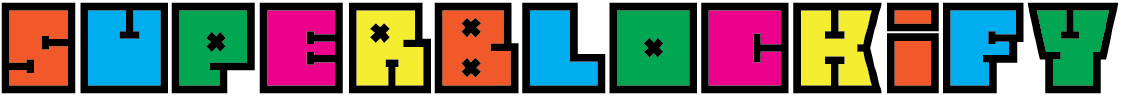

More info: [superblockify.city](https://superblockify.city)

# Population tessellation

This notebook explores the tesselation of population.

In the last two notebooks, we worked on how to determine the population of any given
area using the raster dataset GHS-POP (Global Human Settlement Population Layer) for
the P2023 release. As our goal is to repeatedly determine the population density of
Superblocks, we want to have an effective way to do this. As the Superblocks are made up of
subgraphs of our road network, we showed a way to tessellate using roads.

_A tessellation is..._
... a collection of plane figures that fills the plane with no overlaps and no gaps.
In geometry and mathematics tilings are often done with repeating patterns or shapes.
Voronoi tessellations are usually aperiodic.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
from networkx import ego_graph
from matplotlib._color_data import CSS4_COLORS
from rasterio.features import shapes
from rasterstats import zonal_stats
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.odr import ODR, Model, RealData
from shapely import STRtree
from shapely.geometry import shape
from tqdm import tqdm

from superblockify import get_edge_cells, get_ghsl, resample_load_window, \
    add_edge_population, add_edge_cells, get_population_area

In [ ]:
# Generate Example Voronoi Tessellation
np.random.seed(1671593280)
points = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 0.6]], size=40)
vor = Voronoi(points)
fig = voronoi_plot_2d(vor, figsize=(5, 4), show_vertices=False, line_colors='green',
                      line_width=1.5, line_alpha=0.6, point_size=4)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False,
                right=False, left=False, labelleft=False)

To keep the code effective, we renounce calculating the Voronoi tessellation for each
partition of the road network. Instead, tessellate the whole road network once using
roads and calculate the population and area of each road cell. Then, we can use this
information to determine the population density of each Superblock repeatedly.

There are two approaches we want to consider integrating the population raster data over
the road cells. The first approach is to use up-sampled raster data, as we did before.
The second approach is to polygonize the raster data and intersect the road cells with
it. For both, we need to consider used memory and computation time. Loading in a big
city with an up-sampled raster dataset can take a lot of time and memory, but it
needs to be up-sampled to reach better population approximations. Calculating
intersections between polygons could be computationally heavy.

## Data Preparation

First, let's get an example road network and tessellate it. We are Using _La Crosse,
Wisconsin_ as an example. By the Native American Neshnabé/Potawatomi, it is called
_ensewaksak_.
The working CRS is the World Mollweide projection, as it is an equal-area projection,
and the GHS-POP raster data is in this projection. But the edge cells need to be
calculated in the local CRS, to avoid distortion.

In [ ]:
lc_graph = ox.graph_from_place("La Crosse, La Crosse County, Wisconsin, United "
                               "States",
                               network_type="drive")
lc_graph = ox.project_graph(lc_graph)  # to local UTM zone
# Get Road Cells
lc_road_cells = get_edge_cells(lc_graph)
# Project to World Mollweide
lc_road_cells = lc_road_cells.to_crs("World Mollweide")

In [ ]:
# random color of CSS4_COLORS
lc_road_cells["color_name"] = np.random.choice(list(CSS4_COLORS.keys()),
                                               size=len(lc_road_cells))
lc_road_cells.explore(color="color_name", style_kwds={"color": "black", "opacity": 0.5,
                                                      "weight": 1}, zoom_start=14)

We need to get the GHS-POP raster data for the area of interest. For that we can
use the `get_ghsl` function from the `superblockify` package. It needs a bounding box
of the whole are in Mollweide projection, and it will download the raster data and
return the file path(s) to the raster data. The raster data is in GeoTIFF format.
For that, we take the union of all road cells and get the bounding box of it. When
looking at the union, the _skewness_ of our projection is visible.

In [ ]:
lc_road_cells.unary_union

In [ ]:
lc_bbox = lc_road_cells.unary_union.bounds
lc_ghsl = get_ghsl(lc_bbox)

## Up-sampled Raster Data

Try to load the raster data inside the bounding box into memory and scale up by a
factor of 10. The original cells are 100m x 100m, so the up-sampled cells are 10m x 10m.
For that, we use the `resample_load_window` function from the `superblockify` package.


In [ ]:
lc_ghsl_upsampled, lc_affine_upsampled = resample_load_window(
    file=lc_ghsl, resample_factor=10, window=lc_road_cells)
# The resampling strategy for upscaling is `nearest`, so to conserve the population
# values, we need to divide the population values by the resample factor squared.
lc_ghsl_upsampled /= 10 ** 2

Now, we can use the `zonal_stats` function from the `rasterstats` package to calculate
the population and area of each road cell. Just like we did in the Population Density notebook.

In [ ]:
lc_zonal_stats = zonal_stats(lc_road_cells, lc_ghsl_upsampled,
                             affine=lc_affine_upsampled,
                             stats=["sum"], nodata=0, all_touched=False)
lc_zonal_stats

In [ ]:
# Write to lc_road_cells
lc_road_cells["population_sampled_10"] = [zs_cell["sum"] for zs_cell in lc_zonal_stats]
# pop density in people per square meter
lc_road_cells["pop_density_sampled_10"] = lc_road_cells["population_sampled_10"] / \
                                          lc_road_cells["geometry"].area
# Plot with colormap
lc_road_cells.explore(column="pop_density_sampled_10")

Here we also see cells with a population density of 0. This is the case on Barron Island
in the Mississippi River, as it should, or industrial areas. For especially small
cells, the uncertainty introduced by the raster is higher in comparison to the absolute
population. This effect might be visible here, when specifically looking at the
cells, but when dissolving the cells into Superblocks, the effect will compensate itself.

## Polygonized Raster Data

For this approach first, we need to polygonize the raster data. For that, `rasterio`
has the `features.shapes` function.

Then we will use a :class:`shapely.STRtree` to intersect the road cells with
the polygons. The :class:`shapely.STRtree` is a spatial index, which can be used to
efficiently query the intersection of two geometries. From the tesselation we will
build up the spatial index and query the intersection of the road cells with the
polygons. This way we will distribute the population of the raster to the road cells,
weighted by the intersecting fraction.

In [ ]:
# raster, no upsample
lc_ghsl_unsampled, lc_affine_unsampled = resample_load_window(file=lc_ghsl,
                                                              window=lc_road_cells)
# convert to float32
lc_ghsl_unsampled = lc_ghsl_unsampled.astype(np.float32)

In [ ]:
lc_shapes = [
    {'population': pop, 'geometry': shp}
    for _, (shp, pop) in enumerate(shapes(lc_ghsl_unsampled,
                                          transform=lc_affine_unsampled))
    if pop > 0
]
lc_ghsl_polygons = gpd.GeoDataFrame(
    geometry=[shape(geom["geometry"]) for geom in lc_shapes],
    data=[geom["population"] for geom in lc_shapes],
    columns=["population"],
    crs="World Mollweide"
)
lc_ghsl_polygons.explore(column="population", vmax=260)

One cell has a population of over 500 people; this is why we set the cutoff to 260.
Looking at the cell on a map, a number this high is implausible. For our analysis, we
could provide a sanity-check, where one can set a cutoff. But other than that, this is
a problem of the GHS-POP data. In general, the data quality of the GHS-POP dataset is
very high and well suited for our evaluation, in spite of this outlier.

Let us build up the spatial index of the tesselation.

In [ ]:
lc_road_cells_sindex = STRtree(lc_road_cells.geometry)

In [ ]:
def population_fraction(ghsl_polygon, population, road_cell):
    intersection = road_cell.intersection(ghsl_polygon)
    return population * intersection.area / ghsl_polygon.area

In [ ]:
# Distributing the population over the road cells
# initialize population column
lc_road_cells["population_polygons"] = 0
# Query all geometries at once lc_road_cells_sindex.query(lc_ghsl_polygons["geometry"])
lc_road_cells_loc_pop = lc_road_cells.columns.get_loc("population_polygons")
for pop_cell_idx, road_cell_idx in lc_road_cells_sindex.query(
        lc_ghsl_polygons["geometry"]).T:
    lc_road_cells.iat[road_cell_idx, lc_road_cells_loc_pop] += population_fraction(
        lc_ghsl_polygons.iloc[pop_cell_idx]["geometry"],
        lc_ghsl_polygons.iloc[pop_cell_idx]["population"],
        lc_road_cells.iloc[road_cell_idx]["geometry"]
    )

In [ ]:
from tqdm import tqdm

# Write a version of the function where batches of 200 polygons are queried at once
# to have less overhead - loading bar with tqdm
lc_road_cells["population_polygons"] = 0
for n_batch in tqdm(
        range(0, np.ceil(len(lc_road_cells) / 200).astype(int)),
        desc="Distributing population over road cells",
        total=len(lc_road_cells) // 200 + 1,
        unit="Cells",
        unit_scale=200,
        unit_divisor=200,
):
    for pop_cell_idx, road_cell_idx in lc_road_cells_sindex.query(
            lc_ghsl_polygons.iloc[n_batch * 200:(n_batch + 1) * 200]["geometry"],
            predicate="intersects").T:
        lc_road_cells.iat[
            road_cell_idx, lc_road_cells_loc_pop] += population_fraction(
            lc_ghsl_polygons.iloc[pop_cell_idx + n_batch * 200]["geometry"],
            lc_ghsl_polygons.iloc[pop_cell_idx + n_batch * 200]["population"],
            lc_road_cells.iloc[road_cell_idx]["geometry"]
        )


In [ ]:
# Indexing the population grid
lc_ghsl_polygons_sindex = STRtree(lc_ghsl_polygons.geometry)

In [ ]:
# Distributing the road cells over the population grid
# initialize population column
lc_road_cells["population_polygons"] = 0
# Query all geometries at once
lc_road_cells_loc_pop = lc_road_cells.columns.get_loc("population_polygons")
for road_cell_idx, pop_cell_idx in lc_ghsl_polygons_sindex.query(
        lc_road_cells["geometry"]).T:
    lc_road_cells.iat[
        road_cell_idx, lc_road_cells_loc_pop] += population_fraction(
        lc_ghsl_polygons.iloc[pop_cell_idx]["geometry"],
        lc_ghsl_polygons.iloc[pop_cell_idx]["population"],
        lc_road_cells.iloc[road_cell_idx]["geometry"]
    )

In [ ]:
# Write a version of the function where batches of 200 polygons are queried at once
# to have less overhead - loading bar with tqdm
lc_road_cells["population_polygons"] = 0
for n_batch in tqdm(
        range(0, np.ceil(len(lc_ghsl_polygons) / 200).astype(int)),
        desc="Distributing population over road cells",
        total=len(lc_ghsl_polygons) // 200 + 1,
        unit="Cells",
        unit_scale=200,
        unit_divisor=200,
):
    for road_cell_idx, pop_cell_idx in lc_ghsl_polygons_sindex.query(
            lc_road_cells.iloc[n_batch * 200:(n_batch + 1) * 200]["geometry"],
            predicate="intersects").T:
        lc_road_cells.iat[
            road_cell_idx + n_batch * 200, lc_road_cells_loc_pop] += population_fraction(
            lc_ghsl_polygons.iloc[pop_cell_idx]["geometry"],
            lc_ghsl_polygons.iloc[pop_cell_idx]["population"],
            lc_road_cells.iloc[road_cell_idx + n_batch * 200]["geometry"]
        )


In [ ]:
# Split up road cells into batches
def population_fraction_list(ghsl_polygons, ghsl_populations,
                             overlap_index_pairs, road_cell_geometries):
    """Function returns population count for each road cell in road_cell_geometries"""
    population = np.zeros(len(road_cell_geometries))
    for road_cell_idx, pop_cell_idx in overlap_index_pairs:
        population[road_cell_idx] += population_fraction(
            ghsl_polygons[pop_cell_idx],
            ghsl_populations[pop_cell_idx],
            road_cell_geometries[road_cell_idx]
        )
    return population

In [ ]:
batch_size = 200
lc_road_cells["population_polygons"] = 0
for n_batch in tqdm(
        range(0, np.ceil(len(lc_ghsl_polygons) / batch_size).astype(int)),
        desc="Distributing population over road cells",
        total=len(lc_ghsl_polygons) // batch_size + 1,
        unit="Cells",
        unit_scale=batch_size,
        unit_divisor=batch_size,
):
    # index slice for the cells - for the last batch, the slice can be shorter
    cell_slice = slice(n_batch * batch_size, min((n_batch + 1) * batch_size,
                                                 len(lc_road_cells)))
    lc_road_cells.loc[
        lc_road_cells.index[
            cell_slice], "population_polygons"] = population_fraction_list(
        lc_ghsl_polygons["geometry"],
        lc_ghsl_polygons["population"],
        lc_ghsl_polygons_sindex.query(
            lc_road_cells.iloc[cell_slice]["geometry"],
            predicate="intersects").T,
        lc_road_cells.iloc[cell_slice]["geometry"],
    )

In [ ]:
def _population_fraction_list(ghsl_polygons, ghsl_populations, lc_ghsl_polygons_sindex, road_cell_geometries, slice_n):
    return slice_n, population_fraction_list(
        ghsl_polygons,
        ghsl_populations,
        lc_ghsl_polygons_sindex.query(
                        road_cell_geometries[slice_n],
                        predicate="intersects").T,
        road_cell_geometries[slice_n],
    )

In [ ]:
# Now the same but with multiple workers
from multiprocessing import Pool, cpu_count
from functools import partial

batch_size = 1000
print(f"Batch size: {batch_size}")
lc_road_cells["population_polygons"] = 0
with Pool() as pool:
    slices = (
        slice(n_batch * batch_size, min((n_batch + 1) * batch_size, len(lc_road_cells)))
        for n_batch in range(0, np.ceil(len(lc_ghsl_polygons) / batch_size).astype(int))
    )

    population_sums = list(
        tqdm(
            pool.imap_unordered(
                partial(_population_fraction_list,
                        lc_ghsl_polygons["geometry"].values,
                        lc_ghsl_polygons["population"].values,
                        lc_ghsl_polygons_sindex,
                        lc_road_cells["geometry"].values,
                        ),
                slices,
            ),
            desc="Distributing population over road cells",
            total=len(lc_ghsl_polygons) // batch_size + 1,
            unit="Cells",
            unit_scale=batch_size,
            unit_divisor=batch_size,
        )
    )

    # write the results to the dataframe
    for _, (cell_slice, population) in enumerate(population_sums):
        lc_road_cells.loc[
            lc_road_cells.index[
                cell_slice], "population_polygons"] = population


In [ ]:
lc_road_cells["population_polygons"]

In [ ]:
# pop density in people per square meter
lc_road_cells["pop_density_polygons"] = lc_road_cells["population_polygons"] / \
                                        lc_road_cells["geometry"].area
# Plot with colormap
lc_road_cells.explore(column="pop_density_polygons")

## Uncertainty Estimation

The GHSL datasheet does not give an explicit error estimation for the population
values. However, it gives expected errors of the new GHS-BUILT-S R2023A release at
10m for the various area types, see Table 6 in the report[^1]. For the urban and
built up areas the RMSE (root mean square error) is $0.296$ and the MAPE (mean
absolute percentage error) is $0.218$. Because the population data is inferred from
this data, we can assume the error is of the same magnitude. As the used GHS-POP data
 we use has a lower resolution, we estimate the error for our 100m x 100m cells is
lower. For each population cell, we estimate the uncertainty by a symmetric triangle
distribution of the width $p\cdot \mathrm{MAPE}_\mathrm{urban}$, where $p$ is the
population of each raster cell. From this we get a standard deviation of $u(p) =
\frac{p\cdot \mathrm{MAPE}_\mathrm{urban}}{\sqrt{6}}$ [^2].

For Poland and Portugal case studies Calka and Bielecka estimate MAPEs from 1.0% to
5.71% for the 250m resolution of th 2019 data[^3], while Kuffer et al. stress that
overestimation in low-density or sparsely populated outskirts of cities can be even
bigger. Underestimation can happen for high-density residential areas. Crucial is
also, there is no one accepted standard for the uncertainty estimation of population
data [^4]. This means while our population estimates are not perfect, we can expect
them to show differences between the Superblock estimates.

In our calculation, we do not need a separate numerical uncertainty estimate, as the
mathematical operations we do are only additive and multiplicative. For the cell area
we do not add an uncertainty. Due to this choice, the final uncertainty estimate of
each Superblocks aggregated population density has a standard deviation
$u(\rho_\mathrm{Superblock}) = \sqrt{\sum_{i=1}^N \left(\frac{u(p_i)}{A_i}\right)^2} =
\frac{\rho_\mathrm{Superblock}\cdot \mathrm{MAPE}_\mathrm{urban}}{\sqrt{6}}$, where $N$ is
the number of cells in the Superblock and $A_i$ is the area of the $i$-th cell.

[^1]: Schiavina, M., Freire, S. & MacManus, K. GHS-POP R2023A - GHS population grid
multitemporal (1975-2030). (2023)
[doi:10.2905/2FF68A52-5B5B-4A22-8F40-C41DA8332CFE](https://doi.org/10.2905/2FF68A52-5B5B-4A22-8F40-C41DA8332CFE).

[^2]: Kotz, S. & Van Dorp, J. R. The Triangular Distribution. in Beyond Beta: Other
Continuous Families of Distributions with Bounded Support and Applications 1–32
(WORLD SCIENTIFIC, 2004). [doi:10.1142/9789812701282_0001](https://doi.org/10.1142/9789812701282_0001).

[^3]: Calka, B. & Bielecka, E. GHS-POP Accuracy Assessment: Poland and Portugal Case
Study. Remote Sensing 12, 1105 (2020).

[^4]: Kuffer, M., Owusu, M., Oliveira, L., Sliuzas, R. & van Rijn, F. The Missing
Millions in Maps: Exploring Causes of Uncertainties in Global Gridded Population
Datasets. ISPRS International Journal of Geo-Information 11, 403 (2022).



## Comparison with the Superblock population density

To compare the two approaches, we will show the population densities in a scatter
plot. We will calculate a fit with uncertainties to see the correlation
between the two approaches. The expected result is a linear correlation with a
slope of 1 if both approaches return the same population density. This is why we will
use a linear fit. The fitting procedure will be a ODR (orthogonal distance
regression) fit, as it is more robust than a simple linear regression and can
handle uncertainties in both variables.

In [ ]:
# ODR fit y= B[0] * x + B[1]
model_linear = Model(lambda B, x: B[0] * x + B[1])
mask = (lc_road_cells["pop_density_polygons"] > 0
        ) & (lc_road_cells["pop_density_sampled_10"] > 0)
data = RealData(lc_road_cells["pop_density_polygons"][mask],
                lc_road_cells["pop_density_sampled_10"][mask],
                sx=lc_road_cells["pop_density_polygons"][mask] * 0.218 * 6 ** 0.5,
                sy=lc_road_cells["pop_density_sampled_10"][mask] * 0.218 * 6 ** 0.5)
odr_linear = ODR(data, model_linear, beta0=[1, 0])
output_linear = odr_linear.run()
# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
errorbars = ax.errorbar(x=data.x, y=data.y, xerr=data.sx, yerr=data.sy,
            marker="", capsize=3, alpha=0.3, linestyle="")
x_fit = np.logspace(-6, -1, 200)
# nominal fit
ax.plot(x_fit, output_linear.beta[0] * x_fit + output_linear.beta[1],
        label=r"Linear Fit $\rho_\mathrm{sampled} = "
              f"( {output_linear.beta[0]:.2f} \pm {output_linear.sd_beta[0]:.2f} ) "
              r"\cdot \rho_\mathrm{polygons} + "
              f"( {1e7 * output_linear.beta[1]:.2f} \pm "
              f"{1e7 * output_linear.sd_beta[1]:.2f} ) \cdot 10^7$",
        color="black")
# Uncertainty fit +-2 sigma
ax.plot(x_fit, (output_linear.beta[0] + 2 * output_linear.sd_beta[0]) * x_fit +
        (output_linear.beta[1] + 2 * output_linear.sd_beta[1]),
        color="black", linestyle="--")
ax.plot(x_fit, (output_linear.beta[0] - 2 * output_linear.sd_beta[0]) * x_fit +
        (output_linear.beta[1] - 2 * output_linear.sd_beta[1]),
        color="black", linestyle="--", label="95% Confidence Interval")
# Settings
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Weighted Intersections $\rho_\mathrm{polygons}$ (people/m$^2$)")
ax.set_ylabel(r"Raster Stats $\rho_\mathrm{sampled}$ (people/m$^2$)")
ax.set_title("Comparison of Population Density (10m up-sampled)")
ax.legend()
ax.grid()
# rasterize errorbars
for artist in errorbars.get_children():
    artist.set_rasterized(True)
fig.savefig("../../data/plots/odr_population_density_approaches_10-upsample.pdf",
            bbox_inches="tight")
# plt.show()

This shows both approaches are well proportional to each other. The 95% confidence
interval looks narrow, while the scattered datapoints seem to have a large spread,
but as there are many overlaying datapoints, the thin confidence interval reliably
points out the proportionality. As the slope is a little above 1, we know the raster
stats approach produces a slightly higher population densities.
When we look at the comparison when not up-sampling, we see greater overestimation.

In [ ]:
# Sample approach not upsampled
lc_road_cells["population_unsampled"] = [zs_cell["sum"] for zs_cell in
                                          zonal_stats(lc_road_cells, lc_ghsl_unsampled,
                             affine=lc_affine_unsampled,
                             stats=["sum"], nodata=0, all_touched=False)
                                          ]
# pop density in people per square meter
lc_road_cells["pop_density_unsampled"] = lc_road_cells["population_unsampled"] / \
                                          lc_road_cells["geometry"].area
# ODR fit y= B[0] * x + B[1]
model_linear = Model(lambda B, x: B[0] * x + B[1])
mask = (lc_road_cells["pop_density_polygons"] > 0
        ) & (lc_road_cells["pop_density_unsampled"] > 0)
data = RealData(lc_road_cells["pop_density_polygons"][mask],
                lc_road_cells["pop_density_unsampled"][mask],
                sx=lc_road_cells["pop_density_polygons"][mask] * 0.218 * 6 ** 0.5,
                sy=lc_road_cells["pop_density_unsampled"][mask] * 0.218 * 6 ** 0.5)
odr_linear = ODR(data, model_linear, beta0=[1, 0])
output_linear = odr_linear.run()
# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
errorbars = ax.errorbar(x=data.x, y=data.y, xerr=data.sx, yerr=data.sy,
            marker="", capsize=3, alpha=0.3, linestyle="")
x_fit = np.logspace(-6, -1, 200)
# nominal fit
ax.plot(x_fit, output_linear.beta[0] * x_fit + output_linear.beta[1],
        label=r"Linear Fit $\rho_\mathrm{sampled} = "
              f"( {output_linear.beta[0]:.2f} \pm {output_linear.sd_beta[0]:.2f} ) "
              r"\cdot \rho_\mathrm{polygons} + "
              f"( {1e7 * output_linear.beta[1]:.2f} \pm "
              f"{1e7 * output_linear.sd_beta[1]:.2f} ) \cdot 10^7$",
        color="black")
# Uncertainty fit +-2 sigma
ax.plot(x_fit, (output_linear.beta[0] + 2 * output_linear.sd_beta[0]) * x_fit +
        (output_linear.beta[1] + 2 * output_linear.sd_beta[1]),
        color="black", linestyle="--")
ax.plot(x_fit, (output_linear.beta[0] - 2 * output_linear.sd_beta[0]) * x_fit +
        (output_linear.beta[1] - 2 * output_linear.sd_beta[1]),
        color="black", linestyle="--", label="95% Confidence Interval")
# Settings
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Weighted Intersections $\rho_\mathrm{polygons}$ (people/m$^2$)")
ax.set_ylabel(r"Raster Stats $\rho_\mathrm{sampled}$ (people/m$^2$)")
ax.set_title("Comparison of Population Density (no up-sampling)")
ax.legend()
ax.grid()
# rasterize errorbars
for artist in errorbars.get_children():
    artist.set_rasterized(True)
fig.savefig("../../data/plots/odr_population_density_approaches_no-upsample.pdf",
            bbox_inches="tight")
# plt.show()

In [ ]:
# Relative difference between the two approaches
lc_road_cells["pop_density_diff_samp"] = (lc_road_cells["pop_density_polygons"] /
                                          lc_road_cells["pop_density_sampled_10"]) - 1
lc_road_cells["pop_density_diff_poly"] = (lc_road_cells["pop_density_sampled_10"] /
                                          lc_road_cells["pop_density_polygons"]) - 1
# Plot scatter pop density difference vs. pop density
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(lc_road_cells["pop_density_sampled_10"],
           lc_road_cells["pop_density_diff_samp"], marker=".", alpha=0.3, color="C0",
           label=r"Base = Sampled")
ax.scatter(lc_road_cells["pop_density_polygons"],
           lc_road_cells["pop_density_diff_poly"], marker=".", alpha=0.3, color="C1",
           label=r"Base = Polygons")
ax.set_xscale("log")
# y symlog, starting from 0.01
ax.set_yscale("symlog", linthresh=0.01)
ax.set_xlabel(r"Population Density $\rho_\mathrm{base}$ [people per $\mathrm{m}^2$]")
ax.set_ylabel(r"Relative Difference")
ax.set_title("Relative Difference of Population Density")
ax.grid()
ax.legend()
plt.show()

This plot shows the relative difference between the two approaches.
We see the second approach, weighing the population by the intersecting fraction,
does never underestimate the raster-based approach by less than 1% (cut-off at $-10^{0}$).
The average relative difference is around $\pm 2 \times 10^{-1} \approx \pm 0
.2\%$. For smaller population densities, the relative difference is larger, but
the absolute difference is smaller. Again, this effect might be visible for single
cells, but when dissolving the cells into Superblocks, the effect will compensate itself.

In [ ]:
# Distribution of the densities, next to each other
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(lc_road_cells["pop_density_sampled_10"], bins=100, alpha=0.5, color="C0",
        label=r"Base = Sampled")
ax.hist(lc_road_cells["pop_density_polygons"], bins=100, alpha=0.5, color="C1",
        label=r"Base = Polygons")
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Population Density $\rho$ [people per $\mathrm{m}^2$]")
ax.set_ylabel(r"Number of Cells")
ax.set_title("Distribution of Population Density")
ax.grid()
ax.legend()
plt.show()

We will settle for the second approach, as it is a cleaner approach, not needing
the data up-sampling. This can be useful for large cities.

## Implementation Usage

The package has the function `add_edge_population` which adds the edge attributes
`population`, `area` and `cell_id` to the edges of a graph. Furthermore, there is the
function `get_population_area` which you can pass a graph to summarize the population
and area, respecting the edges with the same geometry. Cells with the same geometry
share the same cell, `cell_id` is used to identify the cells. The function returns
a tuple of the population and area. As for many different Superblock configurations we want
to calculate the population density, `add_edge_population` is called when loading the
graph the first time, so this preprocessing step is only done once.

To demonstrate the implemented functions we will use a new place. This time the 11th
District in Kandahar, Afghanistan. The District is called یولسمه ناحیه.
Kandahar is the second largest city in Afghanistan after Kabul[^5].

[^5]: Wikipedia contributors, "Kandahar," Wikipedia, The Free Encyclopedia,
https://en.wikipedia.org/w/index.php?title=Kandahar&oldid=1159334105 (accessed June
18, 2023).

In [ ]:
kd_graph = ox.graph_from_place("11th District, Kandahar, Kandahar Province, "
                               "Afghanistan", network_type="drive")
kd_graph = ox.project_graph(kd_graph)

In [ ]:
# Add population to the edges
add_edge_population(kd_graph)
# Make up subgraph to calculate the population for
kd_subgraph = ego_graph(kd_graph, list(kd_graph.nodes())[0], radius=15, undirected=True)
# Get population and area
get_population_area(kd_subgraph)  # returns population (people) and area (m^2)

To visualize this, we could plot it using the edges, but as the other plots were also
with edge cells, let's add them.

In [ ]:
add_edge_cells(kd_graph)

In [ ]:
kd_edges = ox.graph_to_gdfs(kd_graph, nodes=False, edges=True)
kd_subgraph_edges = ox.graph_to_gdfs(kd_subgraph, nodes=False, edges=True)
# Add cell geometry to the subgraph edges
kd_subgraph_edges["cell_geometry"] = kd_subgraph_edges.apply(
    lambda x: kd_edges.loc[x.name, "cell"], axis=1)
kd_edges.set_geometry("cell", inplace=True)
kd_subgraph_edges.set_geometry("cell_geometry", inplace=True)
axe = kd_edges.plot(figsize=(8, 8), column="population", legend=True,
                         cmap="viridis", alpha=0.6, edgecolor="white")
kd_subgraph_edges.dissolve().plot(ax=axe, color="none", edgecolor="blue",
                                  linewidth=2)
plt.show()